In [1]:
pip scipy.optimize

ERROR: unknown command "scipy.optimize"
Note: you may need to restart the kernel to use updated packages.


In [20]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import math
from datetime import datetime
from datetime import date
import scipy.optimize as optimize
from scipy.interpolate import make_interp_spline
from dateutil.relativedelta import relativedelta

In [5]:
df = pd.read_excel('apm466data.xlsx')
df['Issue date'] = pd.to_datetime(df['Issue date'])
df['maturity date'] = pd.to_datetime(df['maturity date'])
df

,ISIN,Coupon,Issue date,maturity date,2025-01-06 00:00:00,2025-01-07 00:00:00,2025-01-08 00:00:00,2025-01-09 00:00:00,2025-01-10 00:00:00,2025-01-13 00:00:00,2025-01-14 00:00:00,2025-01-15 00:00:00,2025-01-16 00:00:00,2025-01-17 00:00:00
0,CA135087K940,0.0050,2020-04-03,2025-09-01,98.40,98.41,98.40,98.42,98.37,98.36,98.36,98.40,98.47,98.50
1,CA135087L518,0.0025,2020-10-09,2026-03-01,96.99,96.98,96.97,97.00,96.90,96.91,96.80,96.90,97.01,97.06
2,CA135087L930,0.0100,2021-04-16,2026-09-01,97.01,96.99,97.00,97.03,97.00,96.77,96.71,96.85,97.03,97.07
3,CA135087M847,0.0125,2021-10-15,2027-03-01,96.62,96.59,96.58,96.63,96.39,96.28,96.19,96.36,96.60,96.64
4,CA135087N837,0.0275,2022-05-13,2027-09-01,99.63,99.56,99.64,99.58,99.27,99.13,99.02,99.20,99.50,99.53
5,CA135087P576,0.0350,2022-10-21,2028-03-01,101.82,101.82,101.70,101.72,101.52,101.26,101.02,101.24,101.58,101.65
6,CA135087Q491,0.0325,2023-04-21,2028-09-01,101.10,101.14,100.99,100.94,100.79,100.49,100.19,100.42,100.92,101.02
7,CA135087Q988,0.0400,2023-10-13,2029-03-01,104.07,104.01,103.90,103.87,103.53,103.29,102.99,103.24,103.80,103.90
8,CA135087R895,0.0350,2024-04-08,2029-09-01,102.22,102.14,102.04,101.98,101.59,101.28,101.00,101.27,101.85,101.97
9,CA135087S471,0.0275,2024-03-01,2030-03-01,98.81,98.60,98.53,98.54,97.96,97.61,97.38,97.76,98.40,98.47


In [66]:
def bond_ytm(cur_price, face_val, T, coup_rate, freq=2, guess=0.05):
    freq = float(freq)
    periods = T*freq
    # calculat the coupon for each semi-annual
    coupon = coup_rate*face_val/freq
    dt = [(i+1)/freq for i in range(int(periods))]
    ytm_func = lambda y: sum([coupon/(1+y/freq)**(freq*t) for t in dt]) + face_val/(1+y/freq)**(freq*T) - cur_price
        
    return optimize.newton(ytm_func, guess) *100

cur_time_list = list(df.columns)[4:14]
format_cur_time = []
for i in range(0,10):
    format_cur_time.append(pd.to_datetime(cur_time_list[i]))
format_cur_time

[Timestamp('2025-01-06 00:00:00'),
 Timestamp('2025-01-07 00:00:00'),
 Timestamp('2025-01-08 00:00:00'),
 Timestamp('2025-01-09 00:00:00'),
 Timestamp('2025-01-10 00:00:00'),
 Timestamp('2025-01-13 00:00:00'),
 Timestamp('2025-01-14 00:00:00'),
 Timestamp('2025-01-15 00:00:00'),
 Timestamp('2025-01-16 00:00:00'),
 Timestamp('2025-01-17 00:00:00')]

In [10]:
# calculate the T for each chosen date
T_lst_total = []
for curr in format_cur_time:
    T_lst = []
    for item in df["maturity date"]:
        delta = item - curr
        left = delta.days
        T_lst.append(int(left // 180 +1))
    T_lst_total.append(T_lst)
T_lst_total

# prepare other parameters needed in the ytm calculation
coupon = list(df["Coupon"])
face_val = 100
num_bonds = len(df["maturity date"])

# apply the bond_ytm function
ytm_total =[]
for i in range(len(cur_time_list)):
    ytm_lst = []
    cur_price_lst = df[cur_time_list[i]]
    cur_T_list = T_lst_total[i]
    for j in range(num_bonds):
        cur_price = cur_price_lst[j]
        cur_T = cur_T_list[j]
        cur_coupon = coupon[j]
        cur_ytm = bond_ytm(cur_price, face_val, cur_T,cur_coupon)
#         print(cur_ytm)
        ytm_lst.append(cur_ytm)
    ytm_total.append(ytm_lst)

# organize the ytm
ytm_dict = {}
for idx in range(len(cur_time_list)):
    ytm_dict[cur_time_list[idx]]= ytm_total[idx]
ytm_frame = pd.DataFrame(data = ytm_dict)  

print(ytm_frame)


   2025-01-06  2025-01-07  2025-01-08  2025-01-09  2025-01-10  2025-01-13  \
0    1.313175    1.308041    1.313175    1.302908    1.328580    1.333716   
1    1.275854    1.279324    1.282794    1.272384    1.307098    1.303625   
2    1.777707    1.783001    1.780354    1.772415    1.780354    1.841312   
3    1.963027    1.969480    1.971632    1.960877    2.012559    2.036296   
4    2.817458    2.830252    2.815631    2.826596    2.883367    2.909072   
5    3.207648    3.207648    3.226738    3.223555    3.255422    3.296958   
6    3.093728    3.088082    3.109267    3.116337    3.137570    3.180146   
7    3.469622    3.477264    3.491286    3.495114    3.538582    3.569365   
8    3.238341    3.247655    3.259309    3.266308    3.311918    3.348318   
9    2.876971    2.899559    2.907101    2.906023    2.968742    3.006796   

   2025-01-14  2025-01-15  2025-01-16  2025-01-17  
0    1.333716    1.313175    1.277253    1.261867  
1    1.341854    1.307098    1.268915    1.25157

Text(0, 0.5, 'ytm')

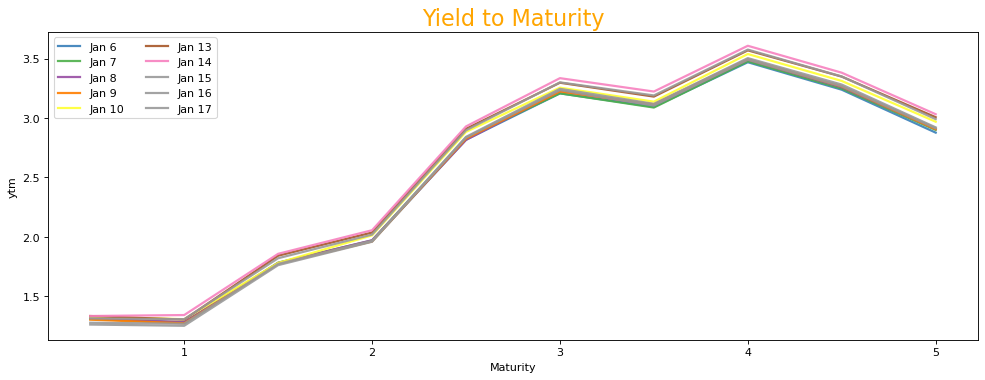

In [64]:
FIVE_YEARS = [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]
 
# Make a data frame    
df1=pd.DataFrame({'x': FIVE_YEARS, 
                 'Jan 6': ytm_total[0], 
                 'Jan 7': ytm_total[1], 
                 'Jan 8': ytm_total[2], 
                 'Jan 9': ytm_total[3], 
                 'Jan 10': ytm_total[4], 
                 'Jan 13': ytm_total[5], 
                 'Jan 14': ytm_total[6], 
                 'Jan 15': ytm_total[7], 
                 'Jan 16': ytm_total[8], 
                 'Jan 17': ytm_total[9] })    

plt.figure(figsize=(15,5), dpi= 80)

# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
num=0
for column in df1.drop('x', axis=1):
    num +=1
    plt.plot(df1['x'], df1[column], marker='', color=palette(num), linewidth=2, alpha=0.9, label=column)

# Add legend
plt.legend(loc=2, ncol=2)
 
# Add titles
plt.title("Yield to Maturity", loc='center', fontsize=20, fontweight=0, color='orange')
plt.xlabel("Maturity")
plt.ylabel("ytm")

In [ ]:
def cal_spot_0(price, face_Val, T):
    spot = - math.log(price / face_Val)/T
    return spot * 100

spot_rate_0 = []

for i in range(10):
    T = (df['maturity date'][0]- cur_time_list[i]).days / 365
    price = df[cur_time_list[i]][0]
    face_Val = 100
    spot_rate = cal_spot_0(price, face_Val, T)
    spot_rate_0.append(spot_rate)


# calculate the dirty price
def dirty_price(curr_date, last_coupon_date, coupon, face_val, curr_price):
    n = (curr_date - last_coupon_date).days
    accured_int = n / 365 * coupon * face_val
    dirty_pri = accured_int + curr_price
    return dirty_pri

In [40]:
# bootstrap for following spot rates
def bootstrap(dirty_price, coupon, face_val, spot_1, t_1, t_2):
    payment_1 = coupon * face_val
    payment_2 = (1 + coupon) * face_val
    in_log = (dirty_price - payment_1 * math.exp(-spot_1 * t_1)) / payment_2
    spot_2 = - math.log(in_log) / t_2    
    return spot_2

total_spot_rate = []
mature_list = df['maturity date']
coupon_list = df['Coupon']
for i in range(10):
    last_coupon_date = mature_list[0] - relativedelta(months = 6)
    cur_time = cur_time_list[i]
    cur_spot = spot_rate_0[i]
    spots = [spot_rate_0[i]]
    face_val = 100
    for j in range(9):
        if j == 0:
            t_1 = (mature_list[0] - cur_time).days /365
            t_2 = (mature_list[1] - cur_time).days /365
            spot_1 = cur_spot
            coupon = coupon_list[1]
            mature_date = mature_list[1]
            curr_price = df[cur_time][0]
            dirty_pri = dirty_price(mature_date, last_coupon_date, coupon, face_val, curr_price)
            spot_2 = bootstrap(dirty_pri, coupon, face_val, spot_1, t_1, t_2)
            spots.append(spot_2 * 100)
            cur_spot = spot_2
            last_coupon_date = mature_list[1]
        else:
            t_1 = (mature_list[j] - mature_list[j - 1]).days /365
            t_2 = (mature_list[j + 1] - mature_list[j - 1]).days /365
            coupon = coupon_list[j + 1] 
            mature_date = mature_list[j + 1]
            curr_price = df[cur_time][j + 1]
            spot_1 = cur_spot
            dirty_pri = dirty_price(mature_date, last_coupon_date, coupon, face_val, curr_price)
            spot_2 = bootstrap(dirty_pri, coupon, face_val, spot_1, t_1, t_2)
            spots.append(spot_2 * 100)
            cur_spot = spot_2
            last_coupon_date = mature_list[j + 1]        
    total_spot_rate.append(spots)
        
spot_dict = {}
for idx in range(len(cur_time_list)):
    spot_dict[cur_time_list[idx]]= total_spot_rate[idx]
spot_frame = pd.DataFrame(data = spot_dict)  
print(spot_frame)

   2025-01-06  2025-01-07  2025-01-08  2025-01-09  2025-01-10  2025-01-13  \
0    2.473624    2.468410    2.494587    2.473636    2.563471    2.612826   
1    1.445542    1.440596    1.452475    1.439082    1.484904    1.504265   
2    4.535730    4.556478    4.546056    4.515044    4.545890    4.784390   
3    5.305578    5.336694    5.347179    5.295297    5.545338    5.658707   
4    4.389128    4.459916    4.378398    4.440125    4.752637    4.894087   
5    3.289435    3.288219    3.409194    3.388193    3.582380    3.839964   
6    3.648137    3.608090    3.756489    3.806985    3.954510    4.252320   
7    1.817913    1.877458    1.982409    2.010857    2.342106    2.572820   
8    2.925675    3.004276    3.102093    3.161421    3.545400    3.852236   
9    5.281619    5.496212    5.566839    5.555717    6.148813    6.507369   

   2025-01-14  2025-01-15  2025-01-16  2025-01-17  
0    2.624186    2.570840    2.468273    2.430166  
1    1.507925    1.477274    1.420873    1.39865

Text(0, 0.5, 'spot rate')

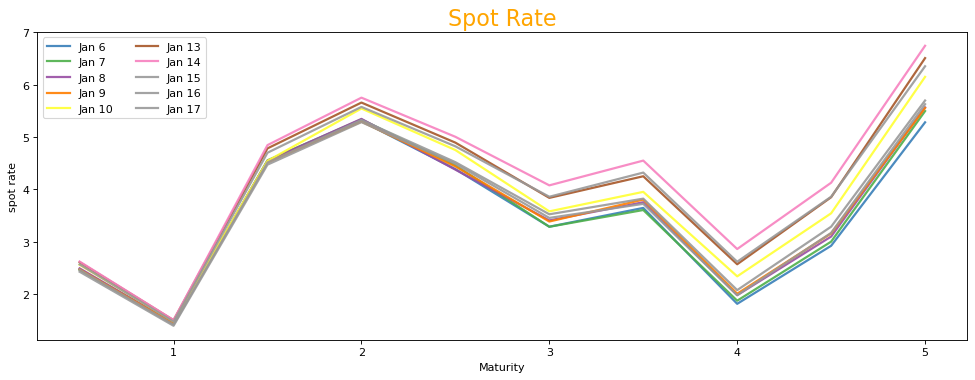

In [62]:
# Plot the spot rate
FIVE_YEARS = [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]
df2=pd.DataFrame({'x': FIVE_YEARS, 
                 'Jan 6': total_spot_rate[0], 
                 'Jan 7': total_spot_rate[1], 
                 'Jan 8': total_spot_rate[2], 
                 'Jan 9': total_spot_rate[3], 
                 'Jan 10': total_spot_rate[4], 
                 'Jan 13': total_spot_rate[5], 
                 'Jan 14': total_spot_rate[6], 
                 'Jan 15': total_spot_rate[7], 
                 'Jan 16': total_spot_rate[8], 
                 'Jan 17': total_spot_rate[9] })    
# size
plt.figure(figsize=(15,5), dpi= 80)

# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
num=0
for column in df2.drop('x', axis=1):
    num +=1
    plt.plot(df2['x'], df2[column], marker='', color=palette(num), linewidth=2, alpha=0.9, label=column)

    # Add legend
plt.legend(loc=2, ncol=2)
 
# Add titles
plt.title("Spot Rate", loc='center', fontsize=20, fontweight=0, color='orange')
plt.xlabel("Maturity")
plt.ylabel("spot rate")

In [48]:
# calculate the one year forward rate
def one_year_forward_rates(spot_rates):
    t_a = 2
    t_b = 1
    forward_rates = []
    for i in range(4):
        r_a = spot_rates[(i + 1) * 2]
        r_b = spot_rates[i * 2]
        forward_rate = (1+r_a / 100)**t_a/(1+r_b / 100)**t_b - 1
        forward_rates.append(abs(forward_rate) * 100)
        t_a += 1
        t_b += 1
    return forward_rates

total_forward_rate = []
for i in range(10):
    forward_rate = one_year_forward_rates(total_spot_rate[i])
    total_forward_rate.append(forward_rate)
print(total_forward_rate)

for_dict = {}
for idx in range(len(cur_time_list)):
    for_dict[cur_time_list[idx]]= total_forward_rate[idx]
for_frame = pd.DataFrame(data = for_dict)

[[6.639333076142551, 4.096539645029873, 1.4565743965731848, 0.08583295908124455], [6.687096336918508, 4.267058354331343, 1.0940635929304054, 0.6240058933973724], [6.638585914119299, 4.043887167884042, 1.912907058999913, 0.525521998889733], [6.597120312087745, 4.290446902911937, 1.9305008960868841, 0.619061747807903], [6.566627467686836, 5.167356220204167, 1.596430314134789, 1.924996871128637], [7.001908921894984, 5.113826299152446, 2.3504816585159904, 2.2671976518860992], [7.117361482581175, 5.323219532388235, 3.2011500609820054, 2.4555779129099564], [6.876362234724009, 5.0685648216239, 2.833491106291519, 2.0373116141327197], [6.602889097819387, 4.533114212925371, 1.763701941602247, 1.1778820703842952], [6.558260265324645, 4.525795173056957, 1.4626029710095523, 0.9862029560356422]]


Text(0, 0.5, 'forward rate')

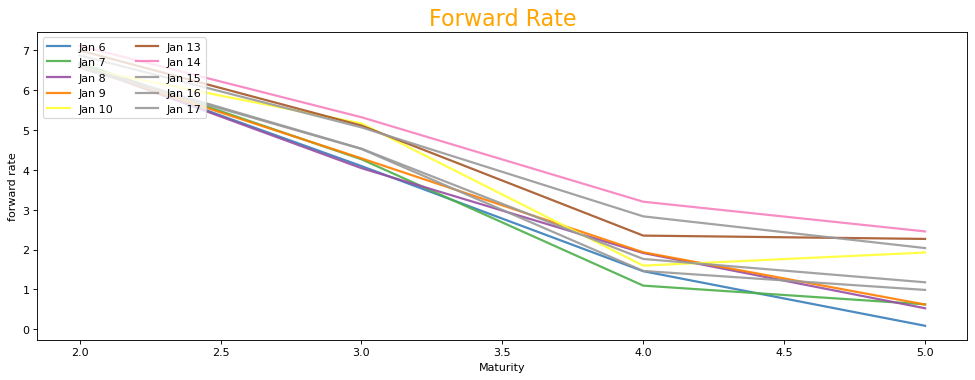

In [60]:
# plot the forward rate
FIVE_YEARS = [i for i in range(2,6)]
df3=pd.DataFrame({'x': FIVE_YEARS, 
                 'Jan 6': total_forward_rate[0], 
                 'Jan 7': total_forward_rate[1], 
                 'Jan 8': total_forward_rate[2], 
                 'Jan 9': total_forward_rate[3],
                 'Jan 10': total_forward_rate[4],
                 'Jan 13': total_forward_rate[5], 
                 'Jan 14': total_forward_rate[6], 
                 'Jan 15': total_forward_rate[7], 
                 'Jan 16': total_forward_rate[8],
                 'Jan 17': total_forward_rate[9]
                })    
# size
plt.figure(figsize=(15,5), dpi= 80)

# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
num=0
for column in df3.drop('x', axis=1):
    num +=1
    plt.plot(df3['x'], df3[column], marker='', color=palette(num), linewidth=2, alpha=0.9, label=column)

    # Add legend
plt.legend(loc=2, ncol=2)
 
# Add titles
plt.title("Forward Rate", loc='center', fontsize=20, fontweight=0, color='orange')
plt.xlabel("Maturity")
plt.ylabel("forward rate")

In [58]:
cov_mat2 = np.zeros([9, 5])
for i in range(0,5):
    for j in range(1, 10):
        X_ij = math.log((ytm_frame.iloc[i*2, j]) / (ytm_frame.iloc[i*2, j-1]))
        cov_mat2[j-1, i] = X_ij
ytm_cov = np.cov(cov_mat2.T)
eig_val_ytm, eig_vec_ytm = np.linalg.eig(ytm_cov)
print(ytm_cov)
print(eig_val_ytm, eig_vec_ytm)


[[0.00018356 0.00016467 0.00013922 0.00013177 0.00013824]
 [0.00016467 0.00029979 0.00015093 0.00017594 0.00015976]
 [0.00013922 0.00015093 0.00013502 0.00010819 0.00011824]
 [0.00013177 0.00017594 0.00010819 0.00013629 0.00012126]
 [0.00013824 0.00015976 0.00011824 0.00012126 0.00011914]]
[7.56695485e-04 8.07687903e-05 3.39142738e-07 1.32851649e-05
 2.27162250e-05] [[-0.44715204 -0.56525394  0.14880414 -0.64836319 -0.19500137]
 [-0.58019232  0.72879805  0.003569   -0.2973618   0.20926897]
 [-0.38540047 -0.3387815   0.27931701  0.4155962   0.697105  ]
 [-0.40303265  0.0691465   0.39722665  0.50398488 -0.64884025]
 [-0.39046522 -0.17258983 -0.86141604  0.25392945 -0.10598071]]


In [56]:
cov_mat2 = np.zeros([9, 4])
for i in range(0,4):
    for j in range(1, 10):
        X_ij = math.log((for_frame.iloc[i, j]) / (for_frame.iloc[i, j-1]))
        cov_mat2[j-1, i] = X_ij
forward_cov = np.cov(cov_mat2.T)
eig_val_for, eig_vec_for = np.linalg.eig(forward_cov)
print(forward_cov)
print(eig_val_for, eig_vec_for)


[[ 0.00092684  0.0007257   0.00616273  0.0067751 ]
 [ 0.0007257   0.00726539 -0.00111783  0.04448545]
 [ 0.00616273 -0.00111783  0.11875275 -0.05939217]
 [ 0.0067751   0.04448545 -0.05939217  0.62701565]]
[6.37040898e-01 1.12477832e-01 4.41702335e-04 4.00019338e-03] [[-0.0095344   0.06171073 -0.99796229 -0.01312077]
 [-0.07021364  0.03659222  0.01603815 -0.99673157]
 [ 0.1135993   0.99128924  0.05982686  0.0293527 ]
 [-0.99099664  0.11044651  0.01532313  0.07411095]]
